
# 🌍 KMeans Clustering on Country Data

This notebook performs clustering on `Country-data.csv` using K-Means to group countries based on economic and social indicators.



## 1️⃣ Load and Inspect Data


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

data = pd.read_csv("Country-data.csv")
print("✅ Data loaded successfully!")
display(data.head())

# Drop non-numeric columns
numeric_df = data.select_dtypes(include=[np.number])
print(f"Numeric columns kept: {list(numeric_df.columns)}")

# Check for nulls or issues
display(data.info())
display(data.describe())


✅ Data loaded successfully!


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


Numeric columns kept: ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


None

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000



## 2️⃣ Explore Relationships — Scatter Plots vs GDP per Capita (gdpp)


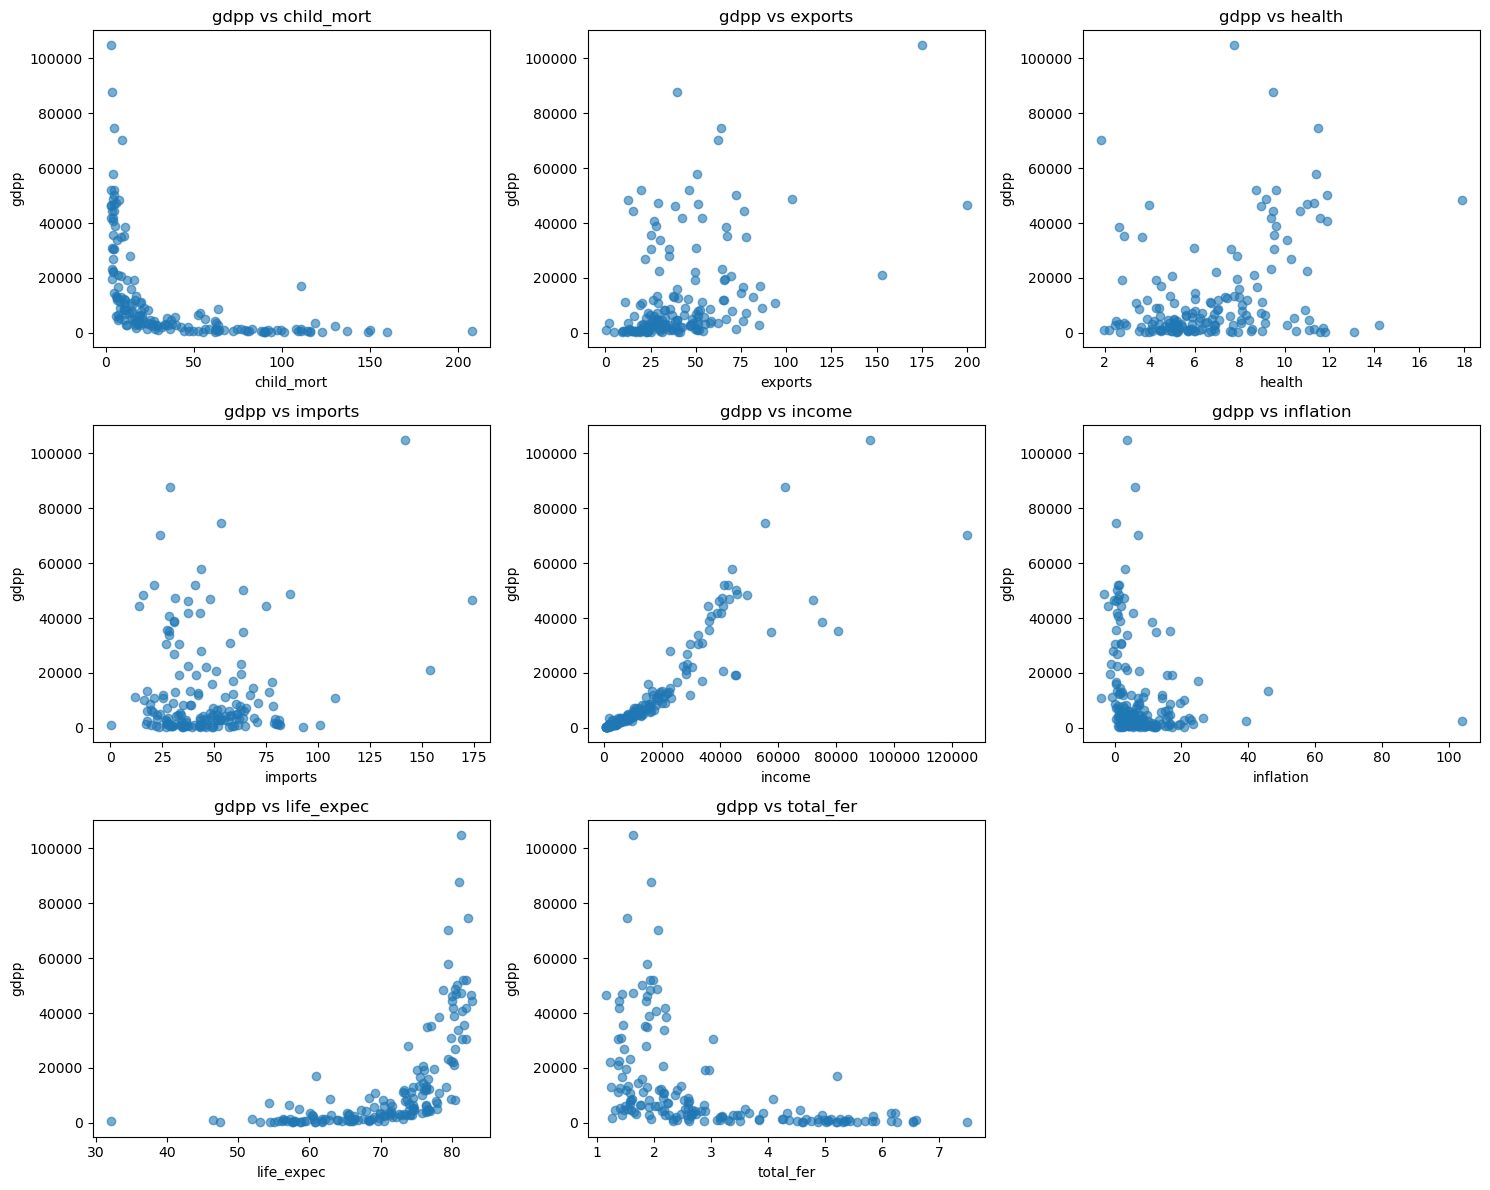

💡 Visually inspect which variables separate best for clustering.


In [2]:

# Plot several scatter plots with different variables against gdpp
plt.figure(figsize=(15, 12))
numeric_cols = numeric_df.columns.drop("gdpp")
for i, col in enumerate(numeric_cols[:9], start=1):
    plt.subplot(3, 3, i)
    plt.scatter(numeric_df[col], numeric_df["gdpp"], alpha=0.6)
    plt.xlabel(col)
    plt.ylabel("gdpp")
    plt.title(f"gdpp vs {col}")
plt.tight_layout()
plt.show()

print("💡 Visually inspect which variables separate best for clustering.")



## 3️⃣ Normalize the Dataset using MinMaxScaler


In [3]:

scaler = MinMaxScaler()
scaled = scaler.fit_transform(numeric_df)
scaled_df = pd.DataFrame(scaled, columns=numeric_df.columns)

print("Scaled numeric data (first 8 rows):")
display(scaled_df.head(8))


Scaled numeric data (first 8 rows):


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242
5,0.057936,0.094006,0.390926,0.091610,0.145437,0.232049,0.861933,0.192429,0.096107
6,0.075463,0.103511,0.160970,0.260065,0.048967,0.110711,0.812623,0.085174,0.028529
7,0.010711,0.098509,0.430081,0.119782,0.327926,0.049626,0.984221,0.123028,0.493171



## 4️⃣ Determine Optimal Number of Clusters — Elbow & Silhouette Methods


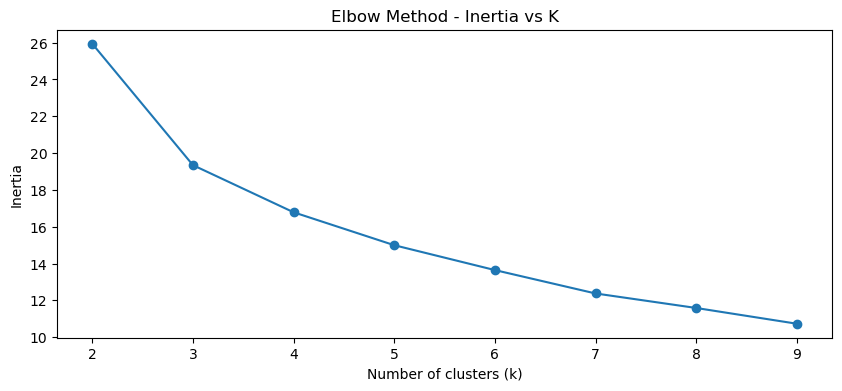

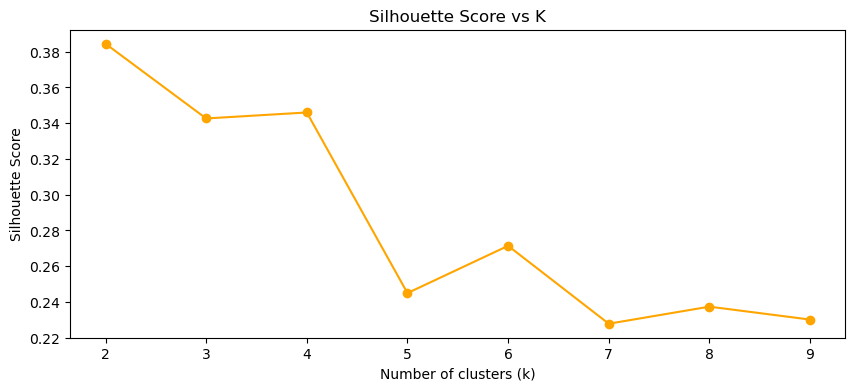

✅ Best number of clusters based on silhouette score: 2


In [4]:

inertias = []
sil_scores = []
K = range(2, 10)

for k in K:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    model.fit(scaled_df)
    inertias.append(model.inertia_)
    sil_scores.append(silhouette_score(scaled_df, model.labels_))

# Plot Elbow curve
plt.figure(figsize=(10,4))
plt.plot(K, inertias, '-o')
plt.title('Elbow Method - Inertia vs K')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.show()

# Plot Silhouette scores
plt.figure(figsize=(10,4))
plt.plot(K, sil_scores, '-o', color='orange')
plt.title('Silhouette Score vs K')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

best_k = K[np.argmax(sil_scores)]
print(f"✅ Best number of clusters based on silhouette score: {best_k}")



## 5️⃣ Fit KMeans Model to Optimal K and Compute Silhouette Score


In [5]:

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(scaled_df)

sil_score = silhouette_score(scaled_df, clusters)
print(f"Silhouette score for k={best_k}: {sil_score:.4f}")

data["cluster"] = clusters
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=numeric_df.columns)
display(centroids)


Silhouette score for k=2: 0.3845


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,15.929310,46.415345,7.036293,48.697414,22994.051724,6.083371,75.343966,2.097155,17833.413793
1,89.084314,29.039588,6.313922,42.779724,3840.254902,11.645000,59.664706,4.883137,1888.980392



## 6️⃣ Visualize Clusters — Child Mortality vs GDPP and Inflation vs GDPP


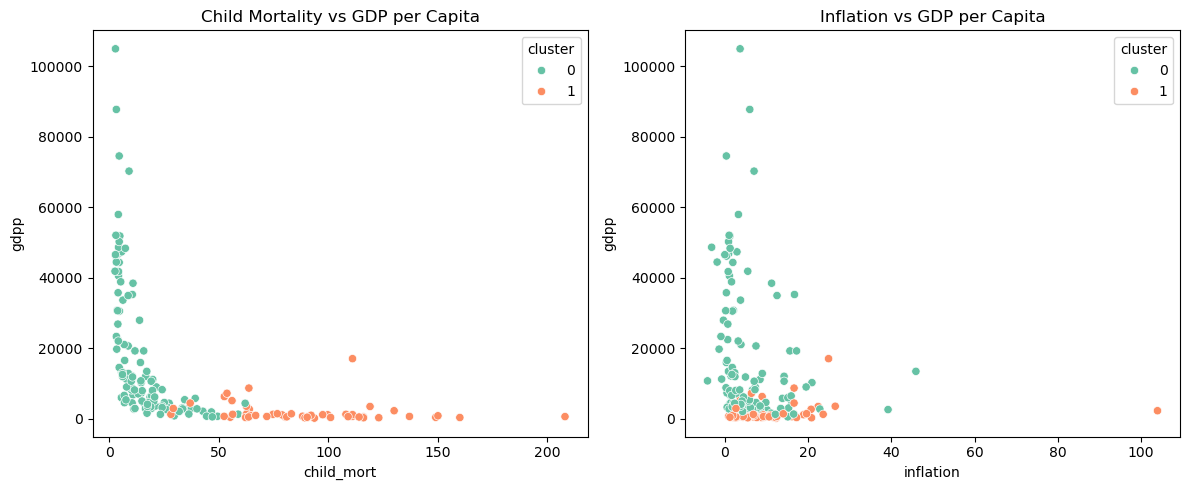

In [6]:

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(data=data, x="child_mort", y="gdpp", hue="cluster", palette="Set2")
plt.title("Child Mortality vs GDP per Capita")

plt.subplot(1,2,2)
sns.scatterplot(data=data, x="inflation", y="gdpp", hue="cluster", palette="Set2")
plt.title("Inflation vs GDP per Capita")
plt.tight_layout()
plt.show()



## 7️⃣ Label Clusters (Low, Middle, High) based on GDPP Centroids


In [7]:

# Rank clusters by centroid gdpp
centroids["cluster"] = centroids.index
centroids = centroids.sort_values("gdpp").reset_index(drop=True)
labels = ["low", "middle", "high"][:len(centroids)]

centroids["label"] = labels
label_map = dict(zip(centroids["cluster"], centroids["label"]))
data["cluster_label"] = data["cluster"].map(label_map)

display(data[["country", "gdpp", "child_mort", "inflation", "cluster", "cluster_label"]].head())


,country,gdpp,child_mort,inflation,cluster,cluster_label
0,Afghanistan,553,90.2,9.44,1,low
1,Albania,4090,16.6,4.49,0,middle
2,Algeria,4460,27.3,16.10,0,middle
3,Angola,3530,119.0,22.40,1,low
4,Antigua and Barbuda,12200,10.3,1.44,0,middle



## 8️⃣ Save Labeled Data and Plots


✅ Clustered data saved to 'country_clusters.csv'


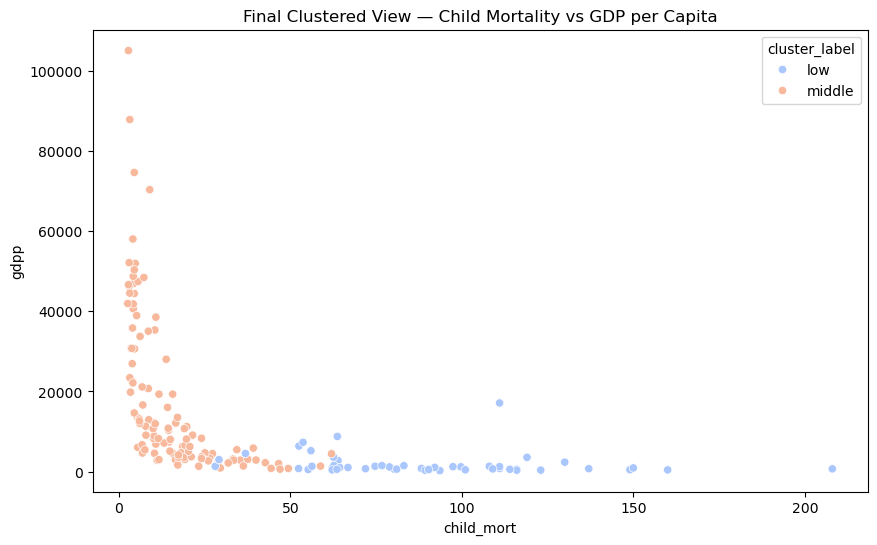

In [8]:

data.to_csv("country_clusters.csv", index=False)
print("✅ Clustered data saved to 'country_clusters.csv'")

# Optional: Save main cluster plots
plt.figure(figsize=(10,6))
sns.scatterplot(data=data, x="child_mort", y="gdpp", hue="cluster_label", palette="coolwarm")
plt.title("Final Clustered View — Child Mortality vs GDP per Capita")
plt.savefig("cluster_childmort_gdpp.png")
plt.show()



### ✅ **Summary**
- Normalized data with MinMaxScaler.
- Found optimal K using elbow and silhouette.
- Fitted KMeans and visualized results.
- Labeled clusters by GDP per capita into Low / Middle / High groups.


